# Sentiment Analysis on IMDB Reviews using LSTM and Keras(CH)-student

<hr>

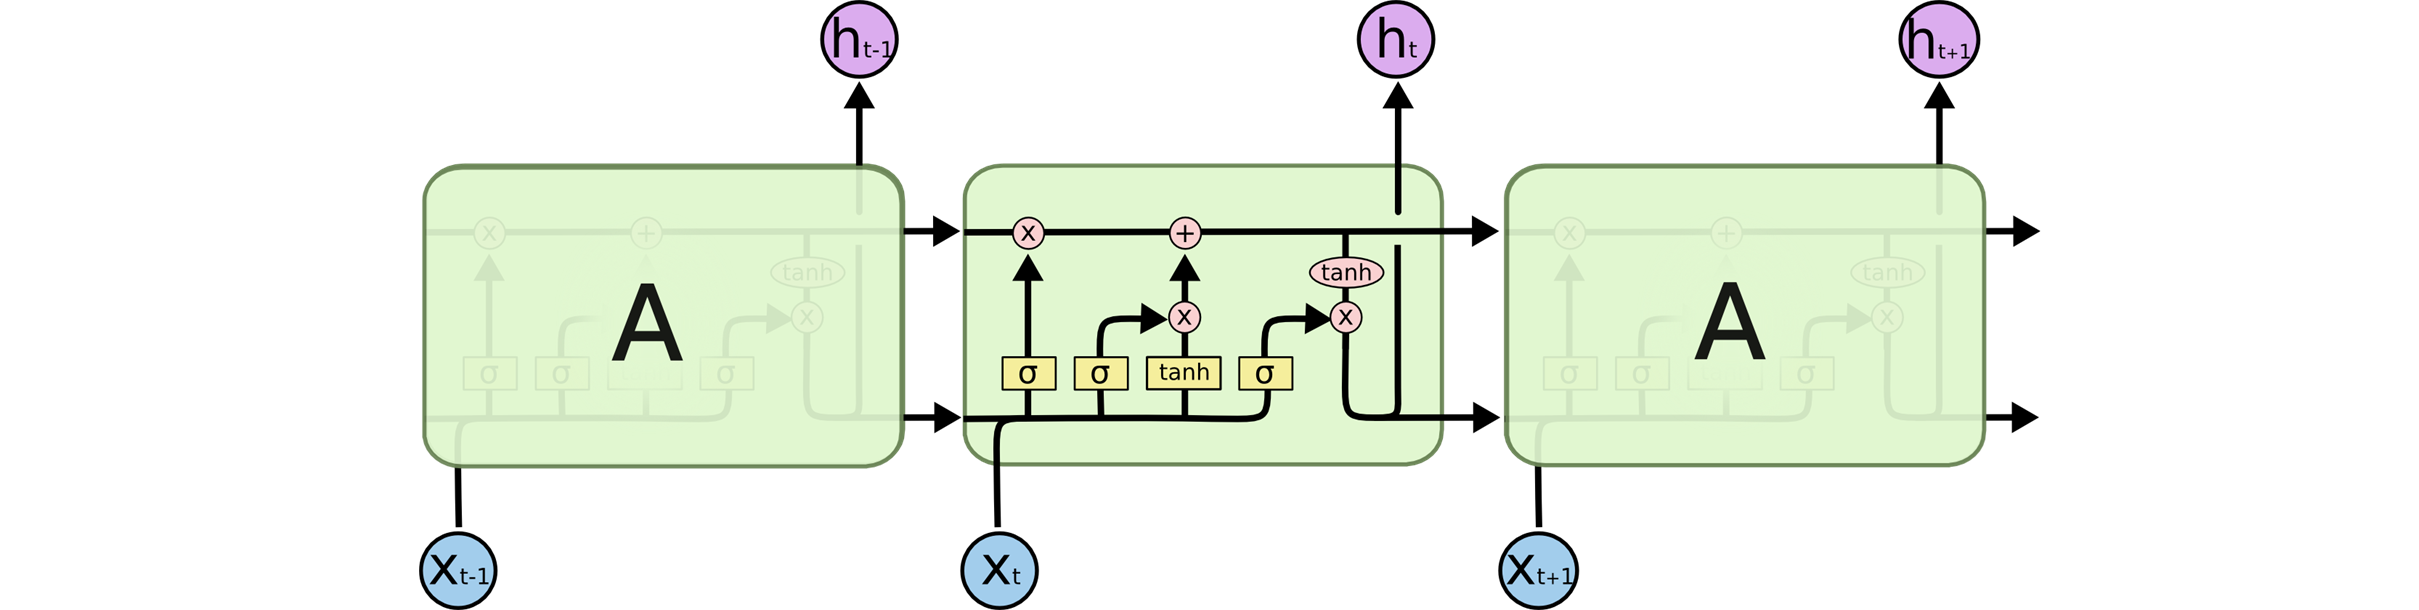


### 步骤
<ol type="1">
    <li>加载数据集（50K IMDB电影评论）</li>
    <li>清洗数据集</li>
    <li>编码情感</li>
    <li>拆分数据集</li>
    <li>对评论进行分词和填充/截断处理</li>
    <li>构建模型架构</li>
    <li>训练和测试</li>
</ol>

<hr>
<i>导入所有库</i>

NLTK（Natural Language Toolkit） 是一个用 Python 编写的自然语言处理（NLP）库，广泛用于文本处理、语言建模、语料库分析、词法分析、语法分析、情感分析等任务。

In [ ]:
import pandas as pd    # 导入 pandas 库，用于加载数据集
import numpy as np     # 导入 numpy 库，用于数学运算
from nltk.corpus import stopwords   # 导入 stopwords 来获取停用词集合
from sklearn.model_selection import train_test_split       # 导入 train_test_split 函数，用于数据集划分
from tensorflow.keras.preprocessing.text import Tokenizer  # 导入 Tokenizer 类，用于将文本编码为整数
from tensorflow.keras.preprocessing.sequence import pad_sequences   # 导入 pad_sequences 函数，用于填充或截断序列
from tensorflow.keras.models import Sequential     # 导入 Sequential 模型，用于建立模型
from tensorflow.keras.layers import Embedding, LSTM, Dense # 导入模型层：Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint   # 导入 ModelCheckpoint 回调函数，用于保存模型
from tensorflow.keras.models import load_model   # 导入 load_model 函数，用于加载保存的模型
import re   # 导入 re 模块，用于正则表达式操作

# 需要启动 NLTK Downloader 并下载所有所需的数据
# import nltk 
# nltk.download()


<hr>
<i>查看数据</i>

In [ ]:
data = pd.read_csv('IMDB Dataset.csv')  # 加载IMDB数据集

print(data)  # 打印数据集内容

english_stops = set(stopwords.words('english'))  # 获取英文停用词集合
sentence = "this is a foo bar sentence"  # 定义一个示例句子
# 过滤掉停用词，并打印剩余单词列表
print([i for i in sentence.split() if i not in english_stops])

print(english_stops)

<hr>
<b>停用词（Stop Word）</b> 是句子中常见的词语，通常搜索引擎会编程忽略这些词（例如 "the"、"a"、"an"、"of" 等）。

<i>声明英文停用词</i>


<hr>

### 加载和清洗数据集

在原始数据集中，评论还未经过处理。仍然包含HTML标签、数字、大写字母和标点符号。这些内容不适合用于训练，因此在 <b>load_dataset()</b> 函数中，除了使用 <b>pandas</b> 加载数据集外，我还对评论进行预处理，包括去除HTML标签、非字母字符（标点符号和数字）、停用词，并将所有评论转换为小写。

### 编码情感

在同一个函数中，我还将情感编码为整数（0 和 1）。其中，0 表示负面情感，1 表示正面情感。


In [ ]:
def load_dataset():
    df = pd.read_csv('IMDB Dataset.csv')  # 读取IMDB数据集
    x_data = df['review']  # 评论/输入数据
    y_data = df['sentiment']  # 情感/输出数据

    # 预处理评论
    x_data = x_data.replace({'<.*?>': ''}, regex=True)  # 移除HTML标签
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex=True)  # 移除非字母字符
    # 移除停用词
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  
    # 转换为小写
    x_data = x_data.apply(lambda review: [w.lower() for w in review])  

    # 编码情感 -> 0 和 1
    y_data = y_data.replace('positive', 1)  # 将正面情感替换为1
    y_data = y_data.replace('negative', 0)  # 将负面情感替换为0

    return x_data, y_data

x_data, y_data = load_dataset()  # 加载并预处理数据集

print('评论')
print(x_data, '\n')  # 打印评论数据
print('情感')
print(y_data)  # 打印情感数据


<hr>

### 分割数据集

在这项工作中，我决定使用 Scikit-Learn 中的 <b>train_test_split</b> 方法，将数据集分为80%的训练集和20%的测试集。使用这种方法时，它会自动对数据集进行洗牌。我们需要洗牌数据，因为在原始数据集中，评论和情感是有序排列的，先列出正面评论，然后是负面评论。通过洗牌数据，可以使数据在模型中分布均匀，从而对预测更准确。


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)  # 将数据集按80%训练集和20%测试集进行划分

print('训练集')
print(x_train, '\n')  # 打印训练集输入数据
print(y_train, '\n')  # 打印训练集输出数据
print('测试集')
print(x_test, '\n')  # 打印测试集输入数据
print(y_test)  # 打印测试集输出数据


<hr>
<i>通过计算所有评论长度的平均值（使用 <b>numpy.mean</b> 函数）来获取最大评论长度的函数</i>


In [ ]:
def get_max_length():
    review_length = []  # 初始化一个列表来存储每条评论的长度
    for review in x_train:
        review_length.append(len(review))  # 将每条评论的长度添加到列表中

    return int(np.ceil(np.mean(review_length)))  # 返回所有评论长度的平均值，并向上取整


<hr>

### 分词并填充/截断评论

神经网络只接受数值数据，因此我们需要对评论进行编码。我使用 <b>tensorflow.keras.preprocessing.text.Tokenizer</b> 将评论编码为整数，其中每个唯一单词根据 <b>x_train</b> 自动索引（使用 <b>fit_on_texts</b> 方法）。<br>
<b>x_train</b> 和 <b>x_test</b> 被转换为整数，使用 <b>texts_to_sequences</b> 方法。

每条评论的长度不同，因此我们需要使用 <b>tensorflow.keras.preprocessing.sequence.pad_sequences</b> 在填充（添加0）或截断单词到相同长度（在这种情况下，是所有评论长度的平均值）。

<b>post</b>，在句子的末尾填充或截断单词<br>
<b>pre</b>，在句子的开头填充或截断单词


In [ ]:
# 编码评论
token = Tokenizer(lower=False)  # 不需要转换为小写，因为在 load_data() 中已经转换
token.fit_on_texts(x_train)  # 使用训练集的文本进行分词器拟合
x_train = token.texts_to_sequences(x_train)  # 将训练集文本转换为整数序列
x_test = token.texts_to_sequences(x_test)  # 将测试集文本转换为整数序列

max_length = get_max_length()  # 获取评论的最大长度

# 对训练集和测试集进行填充和截断
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1  # 计算总词汇数，加1是因为有0填充

print('编码后的训练集\n', x_train, '\n')  # 打印编码后的训练集
print('编码后的测试集\n', x_test, '\n')  # 打印编码后的测试集
print('最大评论长度: ', max_length)  # 打印最大评论长度


<hr>

### 构建模型架构

<b>嵌入层（Embedding Layer）</b>：简单来说，它为 <i>word_index</i> 中的每个单词创建词向量，并通过分析周围的其他单词来分组相关或具有类似含义的单词。

<b>LSTM 层</b>：通过考虑当前输入、先前输出和先前记忆来决定保留还是丢弃数据。LSTM 中有一些重要的组成部分：
<ul>
    <li><b>遗忘门（Forget Gate）</b>：决定是否保留信息或丢弃信息</li>
    <li><b>输入门（Input Gate）</b>：通过将先前的输出和当前输入传递到 sigmoid 激活函数来更新细胞状态</li>
    <li><b>细胞状态（Cell State）</b>：计算新的细胞状态，它与遗忘向量相乘（如果乘以接近 0 的值则丢弃），加上来自输入门的输出以更新细胞状态值。</li>
    <li><b>输出门（Output Gate）</b>：决定下一个隐藏状态，并用于预测</li>
</ul>

<b>全连接层（Dense Layer）</b>：使用权重矩阵和偏置（可选）计算输入，并使用激活函数。我在这项工作中使用 <b>Sigmoid</b> 激活函数，因为输出只有 0 或 1。

优化器为 <b>Adam</b>，损失函数为 <b>Binary Crossentropy</b>，因为输出只有 0 和 1，是一个二进制数。


In [ ]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print("EMBED_DIM",EMBED_DIM)
print("LSTM_OUT",LSTM_OUT)
print("max_length",max_length)
# model.summary()

<hr>

### 训练

训练过程很简单。我们只需要拟合我们的 <b>x_train</b>（输入）和 <b>y_train</b>（输出/标签）数据。在这个训练中，我使用了小批量学习方法，<b>批量大小（batch_size）</b> 设置为 <i>128</i>，<b>epochs</b> 设置为 <i>5</i>。

此外，我添加了一个名为 **checkpoint** 的回调函数，如果模型的准确率比上一个 epoch 改善，则在每个 epoch 结束时将模型保存在本地。


In [ ]:
checkpoint = ModelCheckpoint(
    'models/LSTM.keras',  # 模型保存路径
    monitor='accuracy',  # 监控的指标为准确率
    save_best_only=True,  # 仅保存最优模型
    verbose=1  # 启用详细输出
)


In [ ]:
model.fit(
    x_train,  # 训练集输入数据
    y_train,  # 训练集输出数据
    batch_size=128,  # 批量大小
    epochs=1,  # 训练轮数
    callbacks=[checkpoint]  # 回调函数列表，包括检查点
)


<hr>

### 打印查看模型


In [ ]:
print(model.summary())

<hr>

### 测试

为了评估模型，我们需要使用我们的 <b>x_test</b> 数据进行情感预测，并将预测结果与 <b>y_test</b>（期望输出）数据进行比较。然后，通过将正确预测的数量除以总数据量来计算模型的准确率。结果显示准确率为 <b>?%</b>。(根据每次训练的参数，该数字会有不同)


In [ ]:

y_pred = model.predict(x_test, batch_size=128)  # 对测试集进行预测

# 将预测值转换为二进制（0或1），阈值为0.5
y_pred = (y_pred > 0.5).astype(int)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1  # 计算正确预测的数量

print('正确预测数: {}'.format(true))  # 打印正确预测的数量
print('错误预测数: {}'.format(len(y_pred) - true))  # 打印错误预测的数量
print('准确率: {:.2f}%'.format(true / len(y_pred) * 100))  # 打印准确率，保留两位小数


---

### 加载已保存的模型

加载已保存的模型，并使用它来预测电影评论的情感（正面或负面）。


In [ ]:
loaded_model = load_model('models/LSTM.keras') # 加载已保存的模型

接收一个评论作为输入进行预测


In [ ]:
review = str(input('Movie Review: '))

输入必须在传递给模型进行预测之前进行预处理


In [ ]:
# 预处理输入
regex = re.compile(r'[^a-zA-Z\s]')  # 定义正则表达式，用于匹配非字母字符和空格
review = regex.sub('', review)  # 使用正则表达式移除非字母字符
print('清理后的评论: ', review)  # 打印清理后的评论

words = review.split(' ')  # 将评论拆分成单词列表
# 过滤掉停用词
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)  # 将过滤后的单词列表重新组合成字符串
filtered = [filtered.lower()]  # 转换为小写，并放入列表中

print('过滤后的评论: ', filtered)  # 打印过滤后的评论


我们需要再次对单词进行分词和编码。我使用之前声明的分词器，因为我们想根据模型已知的单词对其进行编码。


In [ ]:
# 将过滤后的评论分词并转换为序列
tokenize_words = token.texts_to_sequences(filtered)
# 对序列进行填充和截断，使其长度与训练时的一致
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
print(tokenize_words)  # 打印分词后的序列


这是预测结果，显示了评论的 **置信度分数**。


In [ ]:
result = loaded_model.predict(tokenize_words)  # 使用加载的模型进行预测
print(result)  # 打印预测结果


如果置信度分数接近0，则该评论为 **负面**。另一方面，如果置信度分数接近1，则该评论为 **正面**。我使用 **0.7** 作为判断正面和负面置信度分数的阈值，因此如果置信度分数等于或大于0.7，则为 **正面**；如果小于0.7，则为 **负面**。


In [ ]:
if result >= 0.7:
    print('positive')  # 如果预测结果大于等于0.7，打印正面情感
else:
    print('negative')  # 否则，打印负面情感
